In [1]:
import numpy as np
import matplotlib.pyplot as plt
from codes import utils, hf, model
from tqdm import tqdm
from functools import partial

When the potential is infinite-range, it is more convenient to write it as $V=V(\mathbf{k})$ than in tight-binding representation.
To exemplify this usage, we again use a 1D tight-binding model with two sublattices:
$$
H_0 = \sum_{i,\sigma} c_{i, B, \sigma}^{\dagger}c_{i, A, \sigma} + c_{i, A, \sigma}^{\dagger}c_{i+1, B, \sigma} + h.c.
$$

In [2]:
hopp = np.kron(np.array([[0, 1], [0, 0]]), np.eye(2))
tb_model = {(0,): hopp + hopp.T.conj(), (1,): hopp, (-1,): hopp.T.conj()}

And use the same worflow as before, except that now we increase the real-space cutoff of $V(\mathbf{k})$ to second neighbors.

In [15]:
def compute_gap(model, nk, nk_dense, filling=2):
    # Find groundstate Hamiltonian on the same grid
    mf_model = hf.find_groundstate_ham(
        model,
        filling=filling,
        nk=nk,
        cutoff_Vk=2,
    )
    # Generate Hamiltonian on a denser k-point grid
    mf_k = utils.kgrid_hamiltonian(
        nk=nk_dense, hk=utils.model2hk(tb_model=mf_model), dim=1
    )
    # Diagonalize groundstate Hamiltonian
    vals, _ = np.linalg.eigh(mf_k)
    # Extract dense-grid Fermi energy
    E_F = utils.get_fermi_energy(vals, filling)
    gap = utils.calc_gap(vals, E_F)
    return gap, vals - E_F

Finally, we define a potential
$$
V(\mathbf{k}) = U \frac{e^{-k}}{\sqrt{1 + k^2}}
$$

In [28]:
def Vk(k, U):
    return U * np.exp(-k[0]) / np.sqrt(1 + k[0]**2) *  np.ones((4, 4))

And compute the spectrum as a function of the interaction strength $U$:

In [29]:
def compute_phase_diagram(
    Us,
    nk,
    nk_dense,
):
    gap = []
    vals = []
    for U in tqdm(Us):
        # onsite interactions
        full_model = model.Model(tb_model=tb_model, Vk=partial(Vk, U=U))
        _gap, _vals = compute_gap(
            model=full_model,
            nk=nk,
            nk_dense=nk_dense,
        )
        gap.append(_gap)
        vals.append(_vals)
    return np.asarray(gap, dtype=float), np.asarray(vals)

In [30]:
# Interaction strengths
Us = np.linspace(0.5, 20, 20, endpoint=True)
nk, nk_dense = 50, 100
gap, vals = compute_phase_diagram(Us=Us, nk=nk, nk_dense=nk_dense)

100%|██████████| 20/20 [00:15<00:00,  1.25it/s]


In [31]:
import xarray as xr

ds = xr.Dataset(
    data_vars=dict(vals=(["Us", "ks", "n"], vals), gap=(["Us"], gap)),
    coords=dict(
        Us=Us, ks=np.linspace(0, 2 * np.pi, nk_dense), n=np.arange(vals.shape[-1])
    ),
)

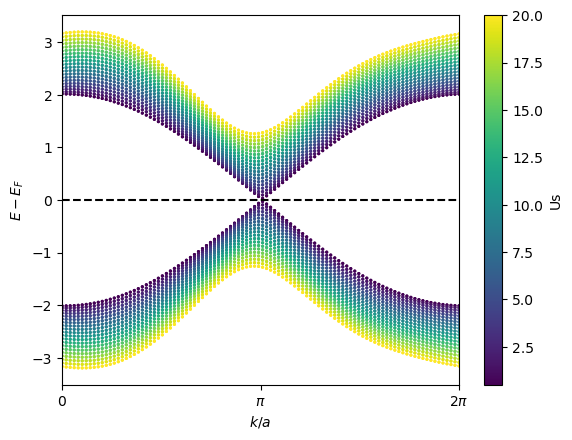

In [32]:
ds.vals.plot.scatter(x="ks", hue="Us", ec=None, s=5)
plt.axhline(0, ls="--", c="k")
plt.xticks([0, np.pi, 2 * np.pi], ["$0$", "$\pi$", "$2\pi$"])
plt.xlim(0, 2 * np.pi)
plt.ylabel("$E - E_F$")
plt.xlabel("$k / a$")
plt.show()

In [33]:
ds.to_netcdf("./data/kspace_potential.nc")